In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [2]:
# Load dataset
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteIPAREL/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteIPAREL/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [10]:
# Write a function with all the data preprocessing steps
def prepare_fashion_mnist_data(fashion_mnist):
  #convert data from uint8 to float32
  fashion_mnist = fashion_mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  fashion_mnist = fashion_mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  fashion_mnist =fashion_mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  fashion_mnist = fashion_mnist.cache()
  #shuffle, batch, prefetch
  fashion_mnist = fashion_mnist.shuffle(1000)
  fashion_mnist = fashion_mnist.batch(32)
  fashion_mnist = fashion_mnist.prefetch(20)
  #return preprocessed dataset
  return fashion_mnist

train_dataset = train_ds.apply(prepare_fashion_mnist_data)
test_dataset = test_ds.apply(prepare_fashion_mnist_data)

In [17]:
# Custom class CNN
# generates a CNN with 2 Convolutional Layers, 2 pooling layers and 2 dropout layers
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=32,             
            kernel_size=[3, 3],    
            padding='same',         
            activation=tf.nn.relu   
        )
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.dropout1 = tf.keras.layers.Dropout(rate=0.3)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=[3, 3],
            padding='same',
            activation=tf.nn.relu
        )
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.dropout2 = tf.keras.layers.Dropout(rate=0.3)
        self.flatten = tf.keras.layers.Reshape(target_shape=(7 * 7 * 64,))
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs, training=True):
        x = self.conv1(inputs)                 
        x = self.pool1(x)                       
        x = self.dropout1(x, training)
        x = self.conv2(x)                       
        x = self.pool2(x)                       
        x = self.dropout2(x, training)
        x = self.flatten(x)                    
        x = self.dense1(x)                      
        x = self.dense2(x)                      
        output = tf.nn.softmax(x)
        return output

In [18]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [19]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = CNN()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.0775
Epoch: 1 starting with accuracy 0.84375
Epoch: 2 starting with accuracy 0.85875
Epoch: 3 starting with accuracy 0.873125
Epoch: 4 starting with accuracy 0.8796875
Epoch: 5 starting with accuracy 0.8778125
Epoch: 6 starting with accuracy 0.8890625
Epoch: 7 starting with accuracy 0.885
Epoch: 8 starting with accuracy 0.8975
Epoch: 9 starting with accuracy 0.893125


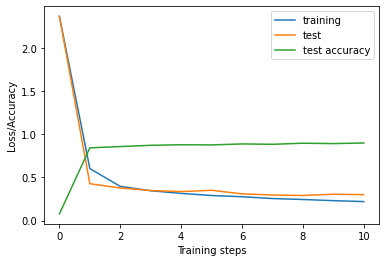

In [20]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()